<a href="https://colab.research.google.com/github/SAMashiyane/Residual_CNN_Explanation/blob/main/Architecture_of_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook, we will use Residual Block to design the Resnet-50**

## **Architecture of Resnet-50**

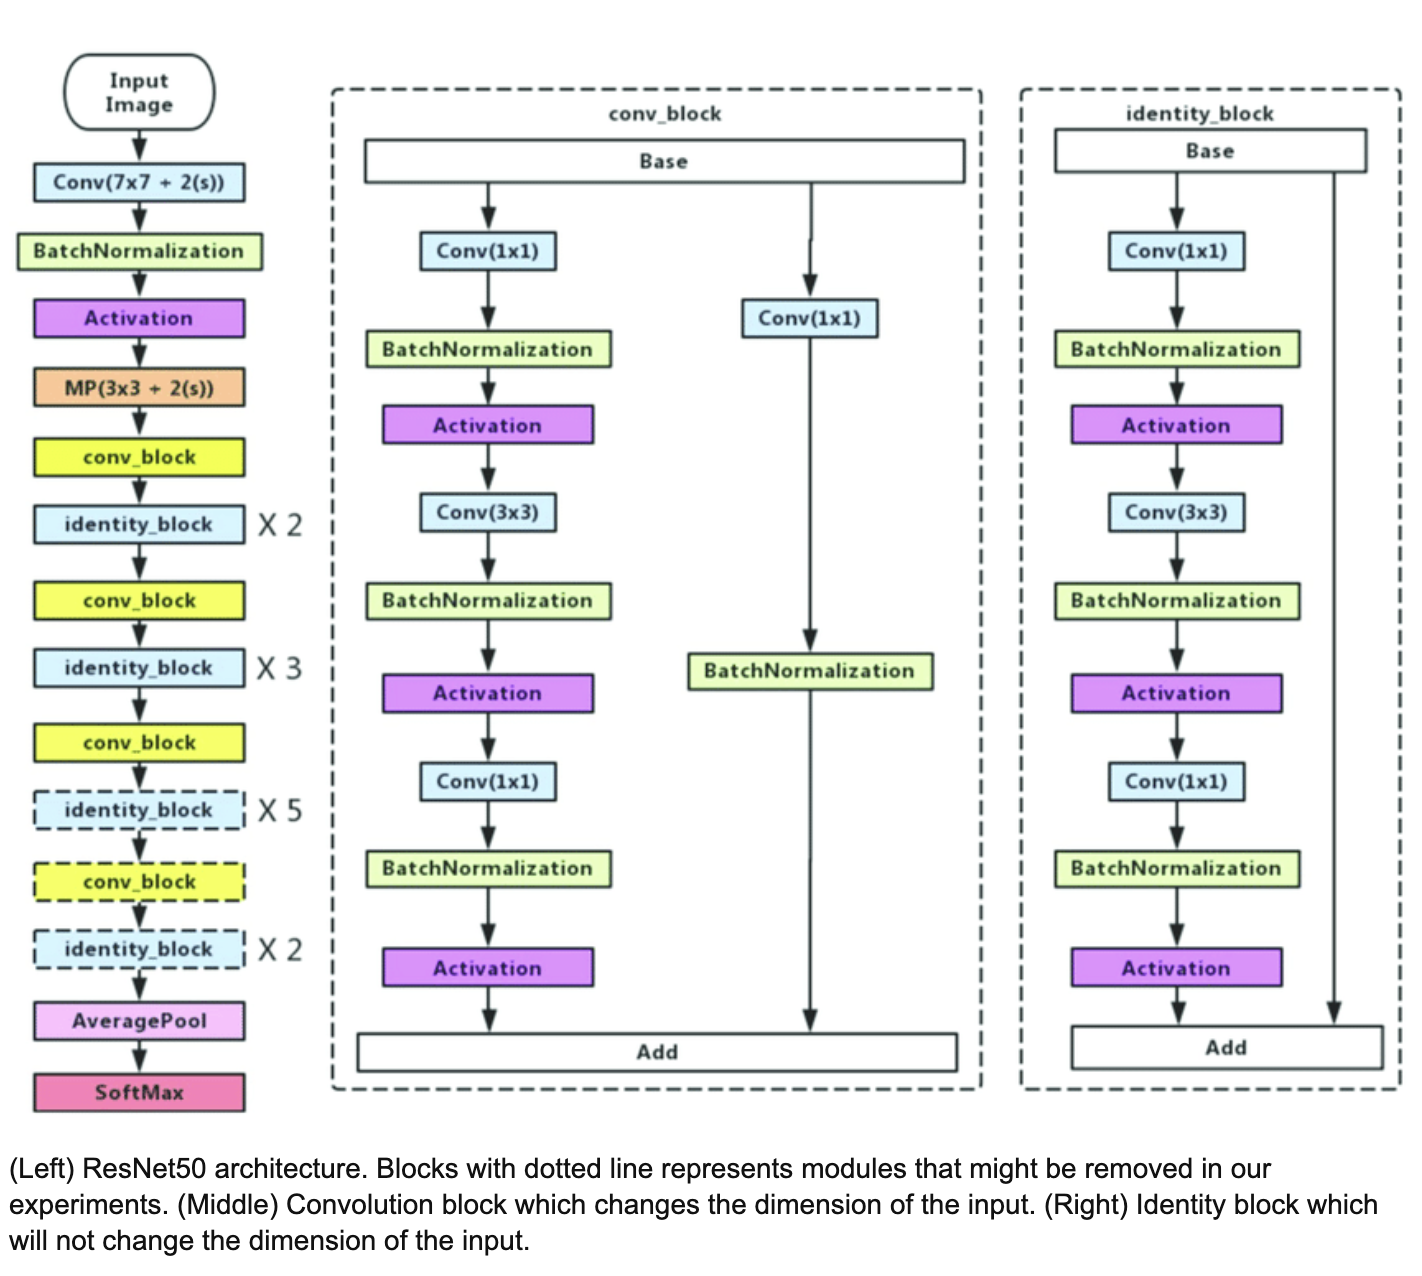

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import glob
import cv2
import shutil
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from torchvision.models import resnet18, resnet34 ,resnet50
import os
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
use_gpu = torch.cuda.is_available()

use_gpu

False

# **Bottlenet (For ResNet 50/101/152) Instead BasicBlok (For ResNet 18/34)**

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1 #  this block do not Bottlenet ( if expansion = 4 Bottlenet --> For ResNet 50/101/152)

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.conv1(x) # 3x3 stride = stride
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = 1
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out    
class Bottleneck(nn.Module):
    expansion = 4 #   if expansion = 4 Bottlenet --> For ResNet 50/101/152) instead BasicBlock 

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) #conv1x1(64,64)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)#conv3x3(64,64)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) #conv1x1(64,256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = stride 
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1 stride = 1
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [5]:
class ResNet(nn.Module):
    # model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs) #resnet 50 
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion: 

            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), #conv1x1(256, 512, 2)
                nn.BatchNorm2d(planes * block.expansion), #batchnrom2d(512)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes * block.expansion #self.inplanes = 128 * 4

        for _ in range(1, blocks): 
            layers.append(block(self.inplanes, planes)) # * 3

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x